## Comparison of Tree Generation Methods

Herein we present are empirical comparison of two random tree generators:

- **Unlabeled generator**: samples uniformly from unlabeled tree isomorphism classes and then assigns arbitrary labels.
- **Prufer generator**: samples uniformly from labeled trees via random Prufer sequences.

We compared the distributions over isomorphism classes for each method using a canonical-ish hash and a few label invariant tree statistics.


/usr/local/lib/python3.12/dist-packages/networkx/algorithms/graph_hashing.py:211: UserWarning: The hashes produced for graphs without node or edge attributes changed in v3.5 due to a bugfix (see documentation).
  node_labels = _init_node_labels(G, edge_attr, node_attr)


n=12, samples=5000
Unique isomorphism classes seen:
  unlabeled->labeled: 551
  prufer (labeled-uniform): 453
Jensen–Shannon divergence between iso-class distributions: 0.1663 nats

Top 10 iso-classes by frequency (unlabeled->labeled):
      20  a01a18cd46d430c09fdeb6573b8a60cc
      18  d5bf4802e31423f2428224fb760e836d
      17  751705d0f26111f5cea57386d8e1e3f8
      17  951ce5a7bae95b928753d9eee595f9a4
      17  7976166f37a9fb51b63443b200ac9264
      16  d2ab7162a754e465610e3676f6559ebc
      16  7188403128f0a829b49ab8e9f8c809f1
      16  a2b7bfa97985300c141b5eab8463e473
      16  b4bb9fc5fde66c08bb110257c38b4db7
      16  ebec81917197f388716452d4967764a0

Top 10 iso-classes by frequency (prufer):
      49  6d241759d2838691c765445ff57dda3f
      48  a33590d7c10d57aedcb58d00663dc18f
      47  c16f30b210f2b9218ad8c2cdcc3892c7
      45  2e0dcd3629e28d941012ae3ed2b2812b
      43  f3e8ad72c620904dd97ea7d8fba969a3
      43  9b679f4884b0bc925cbaa417157d43ad
      43  d9f4fae0330036165d293bf

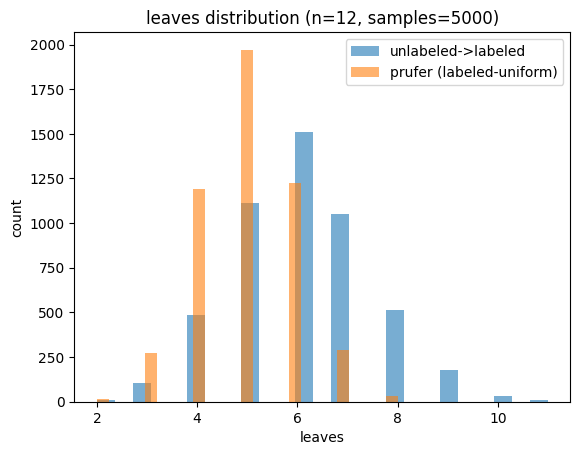

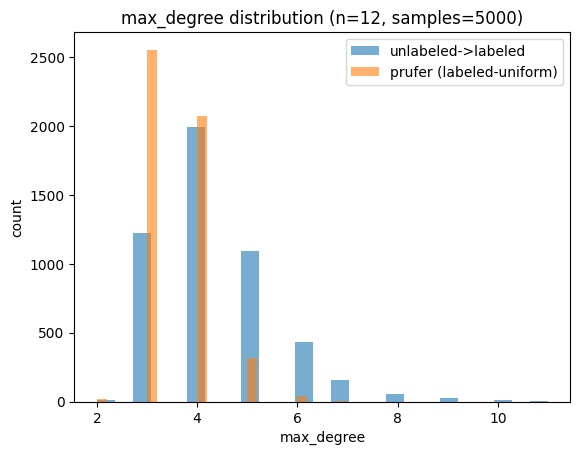

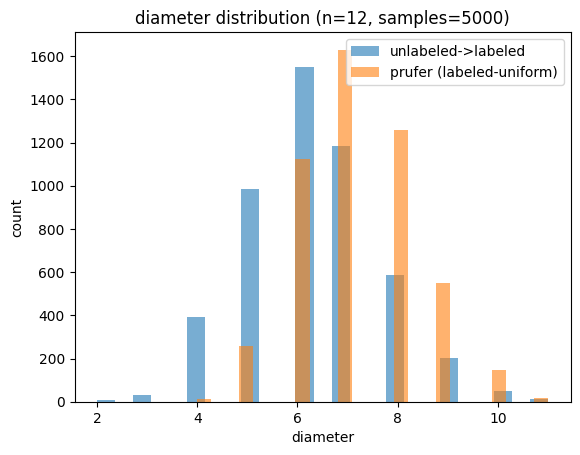

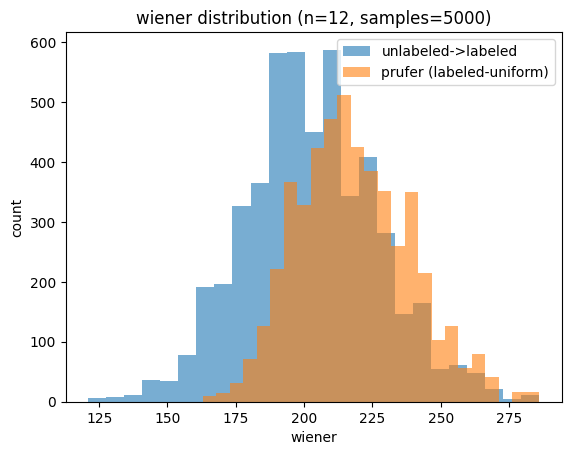

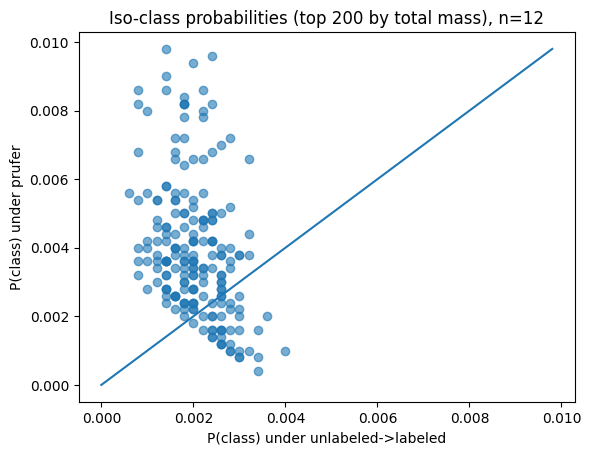

In [1]:
import math
import heapq
from collections import Counter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


# ---------------------------
# Tree generators
# ---------------------------
def random_unlabeled_tree_labeled(n: int, rng: np.random.Generator) -> nx.Graph:
    """
    Generate a uniformly random unlabeled tree on n nodes,
    then arbitrarily label nodes {0,1,...,n-1} for simulation.
    """
    if n < 2:
        raise ValueError("n must be >= 2")

    seed = int(rng.integers(0, 2**32 - 1))
    T = nx.random_unlabeled_tree(n, seed=seed)
    T = nx.convert_node_labels_to_integers(T)
    return T


def prufer_tree(n: int, rng: np.random.Generator) -> nx.Graph:
    """
    Generate a uniform random labeled tree on {0,1,...,n-1}
    using a Prufer sequence sampled with the provided rng.
    """
    if n < 2:
        raise ValueError("n must be >= 2")

    prufer = rng.integers(0, n, size=n - 2)

    T = nx.Graph()
    T.add_nodes_from(range(n))

    degree = [1] * n
    for i in prufer:
        degree[int(i)] += 1

    leaves = [i for i in range(n) if degree[i] == 1]
    heapq.heapify(leaves)

    for a in prufer:
        a = int(a)
        u = heapq.heappop(leaves)
        T.add_edge(a, u)

        degree[a] -= 1
        degree[u] -= 1

        if degree[a] == 1:
            heapq.heappush(leaves, a)

    u = heapq.heappop(leaves)
    v = heapq.heappop(leaves)
    T.add_edge(u, v)
    return T


# ---------------------------
# Helpers: isomorphism class and invariant stats
# ---------------------------

def iso_hash_tree(T: nx.Graph) -> str:
    """
    Approx. isomorphism-invariant hash (very reliable for trees).
    For trees, WL hashing is typically enough to separate classes.
    """
    return nx.weisfeiler_lehman_graph_hash(T, edge_attr=None, node_attr=None)


def tree_stats(T: nx.Graph) -> dict:
    degs = [d for _, d in T.degree()]
    leaves = sum(1 for d in degs if d == 1)
    maxdeg = max(degs)
    # Tree diameter via all-pairs shortest paths for small/moderate n
    diam = nx.diameter(T)
    # Sum of distances (Wiener index) for extra signal (O(n^2) on trees if done smart;
    # NetworkX uses BFS per node, OK for moderate n).
    wiener = sum(
        dist
        for _, dist_map in nx.all_pairs_shortest_path_length(T)
        for dist in dist_map.values()
    ) // 2  # each pair counted twice
    return {
        "leaves": leaves,
        "max_degree": maxdeg,
        "diameter": diam,
        "wiener": wiener,
    }


def jensen_shannon_divergence(p: Counter, q: Counter) -> float:
    """
    JSD between two discrete distributions represented as Counters.
    Returns JSD in nats.
    """
    keys = set(p) | set(q)
    p_total = sum(p.values())
    q_total = sum(q.values())
    if p_total == 0 or q_total == 0:
        return float("nan")

    def kl(a, b):
        s = 0.0
        for k in keys:
            ak = a.get(k, 0) / p_total if a is p else a.get(k, 0) / q_total
            bk = b.get(k, 0)
            if bk == 0:
                continue
            if ak > 0:
                s += ak * math.log(ak / bk)
        return s

    # Build normalized dicts for m
    p_norm = {k: p.get(k, 0) / p_total for k in keys}
    q_norm = {k: q.get(k, 0) / q_total for k in keys}
    m = {k: 0.5 * (p_norm[k] + q_norm[k]) for k in keys}

    # KL(p||m) + KL(q||m) / 2
    def kl_norm(a_norm, m_norm):
        s = 0.0
        for k in keys:
            ak = a_norm[k]
            mk = m_norm[k]
            if ak > 0 and mk > 0:
                s += ak * math.log(ak / mk)
        return s

    return 0.5 * (kl_norm(p_norm, m) + kl_norm(q_norm, m))


# ---------------------------
# Main experiment
# ---------------------------
def compare_generators(
    n: int = 12,
    num_samples: int = 5000,
    seed: int = 0,
    top_k_iso: int = 12,
):
    rng1 = np.random.default_rng(seed)
    rng2 = np.random.default_rng(seed)  # same seed so experiment is repeatable

    # Collect isomorphism class frequencies and invariant stats
    iso_unl = Counter()
    iso_pru = Counter()

    stats_unl = {"leaves": [], "max_degree": [], "diameter": [], "wiener": []}
    stats_pru = {"leaves": [], "max_degree": [], "diameter": [], "wiener": []}

    for _ in range(num_samples):
        T_u = random_unlabeled_tree_labeled(n, rng1)
        T_p = prufer_tree(n, rng2)

        iso_unl[iso_hash_tree(T_u)] += 1
        iso_pru[iso_hash_tree(T_p)] += 1

        su = tree_stats(T_u)
        sp = tree_stats(T_p)
        for k in stats_unl:
            stats_unl[k].append(su[k])
            stats_pru[k].append(sp[k])

    # ----- Summary: isomorphism class distribution -----
    unique_unl = len(iso_unl)
    unique_pru = len(iso_pru)

    jsd = jensen_shannon_divergence(iso_unl, iso_pru)

    print(f"n={n}, samples={num_samples}")
    print(f"Unique isomorphism classes seen:")
    print(f"  unlabeled->labeled: {unique_unl}")
    print(f"  prufer (labeled-uniform): {unique_pru}")
    print(f"Jensen–Shannon divergence between iso-class distributions: {jsd:.4f} nats")
    print()

    # Compare top classes by frequency in each method
    print(f"Top {top_k_iso} iso-classes by frequency (unlabeled->labeled):")
    for h, c in iso_unl.most_common(top_k_iso):
        print(f"  {c:6d}  {h}")
    print()
    print(f"Top {top_k_iso} iso-classes by frequency (prufer):")
    for h, c in iso_pru.most_common(top_k_iso):
        print(f"  {c:6d}  {h}")
    print()

    # ----- Plots: invariant statistics -----
    def plot_hist(name: str, bins: int = 25):
        plt.figure()
        plt.hist(stats_unl[name], bins=bins, alpha=0.6, label="unlabeled->labeled")
        plt.hist(stats_pru[name], bins=bins, alpha=0.6, label="prufer (labeled-uniform)")
        plt.title(f"{name} distribution (n={n}, samples={num_samples})")
        plt.xlabel(name)
        plt.ylabel("count")
        plt.legend()
        plt.show()

    for metric in ["leaves", "max_degree", "diameter", "wiener"]:
        plot_hist(metric)

    # ----- Plot: iso-class frequency scatter (top classes) -----
    # Show how the SAME iso-classes get different weights.
    common = set(iso_unl) | set(iso_pru)
    # focus on most frequent overall
    top = sorted(common, key=lambda h: iso_unl[h] + iso_pru[h], reverse=True)[:200]

    x = np.array([iso_unl[h] / num_samples for h in top])
    y = np.array([iso_pru[h] / num_samples for h in top])

    plt.figure()
    plt.scatter(x, y, alpha=0.6)
    maxv = max(x.max(), y.max())
    plt.plot([0, maxv], [0, maxv])  # y=x reference
    plt.title(f"Iso-class probabilities (top 200 by total mass), n={n}")
    plt.xlabel("P(class) under unlabeled->labeled")
    plt.ylabel("P(class) under prufer")
    plt.show()


if __name__ == "__main__":
    # Try n=10..20. Smaller n makes iso-class effects very easy to see.
    compare_generators(n=12, num_samples=5000, seed=123, top_k_iso=10)


## Comparison of Tree Generation Distributions

We empirically compared two random tree generators on \( n = 12 \) nodes using 5,000 samples each:

- **Unlabeled generator**: samples uniformly from unlabeled tree isomorphism classes and then assigns arbitrary labels.
- **Prufer generator**: samples uniformly from labeled trees via random Prufer sequences.

Although both methods output labeled trees on the same vertex set, they induce different distributions over tree shapes (isomorphism classes).

### Distribution over Isomorphism Classes

The number of distinct isomorphism classes observed under each method was:

- **Unlabeled**: 551 unique classes  
- **Prufer**: 453 unique classes  

This difference indicates that the unlabeled generator explores a broader range of tree shapes, including highly symmetric configurations that are rarely sampled under the labeled uniform distribution. In contrast, Prufer sampling concentrates probability mass on a smaller subset of predominantly asymmetric trees, which admit many distinct labelings.

### Divergence Between Distributions

The induced distributions over isomorphism classes were compared using the Jensen-Shannon divergence (JSD):


$\text{JSD} = 0.1663 \text{ nats}$


This nontrivial divergence confirms that the two generators produce meaningfully different distributions over tree shapes. A JSD of this magnitude indicates structural, not merely sampling-noise-level, differences between the induced measures.

### Concentration Effects

The most frequent isomorphism classes under each generator further highlight this contrast:

- Under **unlabeled sampling**, the most common classes appeared only 16-20 times.
- Under **Prufer sampling**, the most common classes appeared 41-49 times.

This reflects the theoretical bias of Prufer sampling toward tree shapes with many distinct labelings, causing probability mass to concentrate on a small number of high-entropy, low-symmetry trees. Conversely, uniform sampling over unlabeled trees distributes mass more evenly across shapes, reducing concentration.

Notably, the most frequent isomorphism classes under the two generators do not overlap, indicating that the dominant tree shapes differ qualitatively between the two distributions.

### Interpretation

These results are consistent with known theoretical properties:

- **Prufer sampling** is uniform over labeled trees, implicitly weighting each isomorphism class in proportion to its number of distinct labelings.
- **Unlabeled sampling** is uniform over tree shapes, thereby over representing symmetric trees relative to the labeled uniform model.

As a result, the two generators are not interchangeable when the analysis depends on structural properties of the underlying tree rather than on labeled-node identities alone.
